# Example Pythonic image-based single-cell profiling

The following is an example of performing image-based single-cell profiling using 
Python tools without leaving the kernel for GUI-based interaction.

- load ExampleHuman images from the CellProfiler/examples repo
- segment nuclei with Cellpose (v3 or v4)
- extract features with cp_measure (classic CP-style measures)
- write incrementally to LanceDB:
    * images_raw: raw images as flattened lists (+ shape/dtype)
    * masks: segmentation masks as flattened lists (+ lineage to image & algo)
    * nuclei_features: per-object features (cp_measure)
    * run_log: per-file processing status

In [1]:
from __future__ import annotations

import pathlib
import shutil
import subprocess
import tempfile
from pathlib import Path
from pprint import pp
from shutil import copy2, copytree
from typing import Dict, List, Tuple

import cellpose
import imageio.v3 as iio
import lancedb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cellpose import models as cp_models

try:
    from cellpose import version as CP_VERSION
except Exception:
    CP_VERSION = "unknown"
from cp_measure.bulk import get_core_measurements

REPO_URL = "https://github.com/CellProfiler/examples.git"
SUBPATH = "ExampleHuman"
DEST_DIR = pathlib.Path("data/ExampleHuman")

IMAGES_DIR = Path("data/ExampleHuman/images")
LANCE_DIR = Path("./data/lance_db")

TABLE_FEATURES = "compartment_nuclei"
TABLE_LOG = "run_log"
TABLE_IMAGES = "images"
TABLE_MASKS = "masks"

MODEL_TYPE = "nuclei"  # Cellpose pretrained nuclei model
GPU = True  # set True if you have CUDA ready
MIN_OBJECTS_TO_SAVE = 1
CHANNELS = (0, 0)  # single-channel nuclei, compatible with Cellpose v3/v4

# remove the lance database to refresh on each run
if pathlib.Path(LANCE_DIR).is_dir():
    shutil.rmtree(LANCE_DIR)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	darwin 
python version: 	3.11.11 
torch version:  	2.8.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [2]:
# if we don't have the data already, create it
if not pathlib.Path(DEST_DIR).exists():
    DEST_DIR.mkdir(parents=True, exist_ok=True)

    with tempfile.TemporaryDirectory() as tmp:
        # Clone shallowly for speed
        subprocess.run(["git", "clone", "--depth", "1", REPO_URL, tmp], check=True)

        src = Path(tmp) / SUBPATH
        if not src.exists():
            raise FileNotFoundError(f"Subpath {SUBPATH!r} not found in the repo.")

        # Copy the CONTENTS of ExampleHuman directly under data/
        for entry in src.iterdir():
            target = DEST_DIR / entry.name
            if entry.is_dir():
                copytree(entry, target, dirs_exist_ok=True)
            else:
                copy2(entry, target)

pp(list(pathlib.Path(DEST_DIR).rglob("*")))

[PosixPath('data/ExampleHuman/images'),
 PosixPath('data/ExampleHuman/ExampleHuman.cppipe'),
 PosixPath('data/ExampleHuman/README.md'),
 PosixPath('data/ExampleHuman/images/AS_09125_050116030001_D03f00d0.tif'),
 PosixPath('data/ExampleHuman/images/AS_09125_050116030001_D03f00d1.tif'),
 PosixPath('data/ExampleHuman/images/AS_09125_050116030001_D03f00d2.tif')]


In [15]:
type(
    lancedb.connect(LANCE_DIR).create_table(
        "something", pd.DataFrame({"sometiing": [12]})
    )
)

lancedb.table.LanceTable

In [3]:
# create functions which can help us run the pipeline


def ndarray_to_list(arr: np.ndarray) -> List[float | int]:
    """
    Flatten to a Python list in C-order.
    Cast integer arrays to int (to keep sizes smaller) and float arrays to float.
    """
    if np.issubdtype(arr.dtype, np.integer):
        return arr.ravel(order="C").astype(np.int64, copy=False).tolist()
    else:
        return arr.ravel(order="C").astype(np.float32, copy=False).tolist()


def to_float01(img: np.ndarray) -> np.ndarray:
    """Scale image to float32 in [0,1] as cp_measure expects."""
    if img.dtype in (np.float32, np.float64):
        return np.clip(img.astype(np.float32, copy=False), 0.0, 1.0)
    img = img.astype(np.float32, copy=False)
    if np.issubdtype(img.dtype, np.integer):
        maxv = float(np.iinfo(img.dtype).max)
    else:
        maxv = float(img.max() or 1.0)
    if maxv != 0:
        img /= maxv
    return np.clip(img, 0.0, 1.0)


def list_images(root: Path) -> List[Path]:
    exts = (".tif", ".tiff", ".png", ".jpg", ".jpeg")
    return sorted([p for p in root.rglob("*") if p.suffix.lower() in exts])


# ---------- LanceDB helpers (lazy creation, schema-safe) ----------


def get_or_create_table(
    db: lancedb.db.LanceDBConnection, table_name: str, df_first_batch: pd.DataFrame
) -> lancedb.table.LanceTable:
    """
    Lazily create (or safely recreate) a table from the first batch df.
    If an incompatible table exists, drop and recreate with the new schema.
    """
    names = set(db.table_names())
    if table_name not in names:
        return db.create_table(table_name, df_first_batch)

    tbl = db.open_table(table_name)
    try:
        # quick compatibility probe
        tbl.add(df_first_batch.iloc[0:0])
        return tbl
    except Exception:
        print(f"[lancedb] Recreating table '{table_name}' with current schema.")
        db.drop_table(table_name)
        return db.create_table(table_name, df_first_batch)


def ensure_log_table(
    db: lancedb.db.LanceDBConnection, name: str
) -> lancedb.table.LanceTable:
    names = set(db.table_names())
    if name not in names:
        return db.create_table(
            name, pd.DataFrame([{"image": "", "status": "", "n_objects": 0}])
        ).delete("n_objects == 0")


# ---------- Cellpose v3/v4 compatibility ----------


def make_cellpose_model(model_type: str, gpu: bool) -> cellpose.models.CellposeModel:
    """
    Return a Cellpose model instance that works with Cellpose v3 or v4.
    """
    # v3 API
    if hasattr(cp_models, "Cellpose"):
        return cp_models.Cellpose(model_type=model_type, gpu=gpu)

    # v4 API
    if hasattr(cp_models, "CellposeModel"):
        try:
            return cp_models.CellposeModel(gpu=gpu, model_type=model_type)
        except TypeError:
            # alt signature in some builds
            return cp_models.CellposeModel(gpu=gpu, pretrained_model=model_type)

    raise RuntimeError("No compatible Cellpose model class found (v3 or v4).")


def cellpose_eval(
    model: cellpose.models.CellposeModel,
    img_f: np.ndarray,
    channels: Tuple[int, int] = (0, 0),
) -> Tuple[np.ndarray, float]:
    """
    Run model.eval and return (masks, diams_scalar).
    If Cellpose returns a vector of diameters, return its nanmean.
    If missing/unavailable, return NaN.
    """
    result = model.eval(img_f, channels=list(channels))

    # Unpack results across versions
    if isinstance(result, tuple):
        if len(result) >= 4:
            masks, flows, styles, diams = result[:4]
        elif len(result) == 3:
            masks, flows, styles = result
            diams = None
        elif len(result) == 2:
            masks, _ = result
            diams = None
        else:
            masks = result[0]
            diams = None
    else:
        masks, diams = np.asarray(result), None

    masks = np.asarray(masks)

    # Normalize diams to a scalar
    if diams is None:
        diam_scalar = float("nan")
    elif np.isscalar(diams):
        diam_scalar = float(diams)
    else:
        # handle list/ndarray cases
        arr = np.asarray(diams, dtype=np.float64)
        if arr.size == 0:
            print("NEGATIVE!")
            diam_scalar = float("nan")
        else:
            with np.errstate(all="ignore"):
                diam_scalar = float(np.nanmean(arr))

    return masks, diam_scalar


def main() -> None:  # noqa: PLR0915, C901
    # Connect LanceDB + ensure log table
    db = lancedb.connect(str(LANCE_DIR))
    ensure_log_table(db, TABLE_LOG)
    log_tbl = db.open_table(TABLE_LOG)

    # Init Cellpose (v3 or v4)
    model = make_cellpose_model(MODEL_TYPE, GPU)

    # cp_measure measurement functions (intensity, size/shape,
    # texture, zernike, granularity, radial, etc.)
    measurements = get_core_measurements()

    images = list_images(IMAGES_DIR)
    if not images:
        raise SystemExit(f"No images found under: {IMAGES_DIR.resolve()}")

    for img_path in [images[0]]:
        try:
            # --- read & (optionally) select nuclei channel ---
            img = iio.imread(img_path)
            file_shape = tuple(img.shape)
            file_dtype = str(img.dtype)

            # If multichannel (H,W,C), pick the first channel
            # for minimal demo storage/seg
            dims = 3
            if img.ndim == dims and img.shape[-1] in (2, 3, 4):
                nuc_img = img[..., 0]
                stored_channels = 1
            else:
                nuc_img = img
                stored_channels = 1  # demo stores single-channel images

            # --- store raw image as flattened list into images_raw ---
            img_record = pd.DataFrame(
                [
                    {
                        "filename": img_path.name,
                        "height": int(nuc_img.shape[0]),
                        "width": int(nuc_img.shape[1]),
                        "channels": int(stored_channels),
                        "dtype": str(nuc_img.dtype),
                        "image": ndarray_to_list(nuc_img),  # <— list column
                        # provenance about original file before channel selection
                        "file_shape": str(file_shape),
                        "file_dtype": file_dtype,
                    }
                ]
            )

            get_or_create_table(db, TABLE_IMAGES, img_record)

            # --- prepare float image for segmentation & features ---
            img_f = to_float01(nuc_img)

            # --- segment ---
            masks, diams = cellpose_eval(model, img_f, channels=CHANNELS)

            # --- store mask as flattened list with lineage into masks table ---
            labels = np.unique(masks)
            labels = labels[labels > 0]
            n_obj = int(labels.size)

            mask_record = pd.DataFrame(
                [
                    {
                        "filename": img_path.name,
                        "algo_name": "cellpose",
                        "algo_version": CP_VERSION,
                        "model_type": MODEL_TYPE,
                        "channels": str(CHANNELS),
                        "n_objects": n_obj,
                        "height": int(masks.shape[0]),
                        "width": int(masks.shape[1]),
                        "dtype": "int32",
                        "image": ndarray_to_list(
                            masks.astype(np.int32, copy=False)
                        ),  # <— list column
                    }
                ]
            )

            get_or_create_table(db, TABLE_MASKS, mask_record)

            # --- compute cp_measure features ---
            if n_obj < MIN_OBJECTS_TO_SAVE:
                log_tbl.add(
                    [
                        {
                            "image_filename": str(img_path),
                            "status": "no_objects",
                            "n_objects": n_obj,
                        }
                    ]
                )
                print(f"- {img_path.name}: no objects")
                continue

            feature_arrays: Dict[str, np.ndarray] = {}
            for _, fn in measurements.items():
                res = fn(masks, img_f)  # (mask, image) measurements
                feature_arrays.update(res)

            rows = []
            for i, obj_id in enumerate(labels, start=0):
                row = {
                    "image_filename": img_path.name,
                    "nuclei_object_number": int(obj_id),
                }
                for feat_name, arr in feature_arrays.items():
                    if i < len(arr):
                        val = arr[i]
                        # ensure python scalar
                        try:
                            row[feat_name] = (
                                float(val)
                                if np.ndim(val) == 0
                                else float(np.array(val).item())
                            )
                        except Exception:
                            row[feat_name] = float("nan")
                rows.append(row)

            df_features = pd.DataFrame(rows)

            get_or_create_table(db, TABLE_FEATURES, df_features)

            log_tbl.add([{"image": str(img_path), "status": "ok", "n_objects": n_obj}])
            print(f"✓ {img_path.name}: {n_obj} objects")

        except Exception as ex:
            log_tbl.add(
                [
                    {
                        "image": str(img_path),
                        "status": f"error: {type(ex).__name__}: {ex}",
                        "n_objects": 0,
                    }
                ]
            )
            print(f"✗ {img_path.name}: {ex}")

In [4]:
%%time
# run the pipeline and show the time duration
main()

model_type argument is not used in v4.0.1+. Ignoring this argument...
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
/Users/buntend/Documents/work/serpula_rasa/.venv/lib/python3.11/site-packages/cp_measure/core/measureobjectintensitydistribution.py:279: RuntimeWarning: invalid value encountered in divide
  radial_means = numpy.ma.masked_array(radial_values / pixel_count, mask)


✓ AS_09125_050116030001_D03f00d0.tif: 329 objects
CPU times: user 3.65 s, sys: 898 ms, total: 4.55 s
Wall time: 7.34 s


In [5]:
db = lancedb.connect(LANCE_DIR)
db.table_names()

['compartment_nuclei', 'images', 'masks', 'run_log']

In [6]:
# show nuclei features
db.open_table("compartment_nuclei").to_pandas()

,image_filename,nuclei_object_number,RadialDistribution_FracAtD_1of4,RadialDistribution_MeanFrac_1of4,RadialDistribution_RadialCV_1of4,RadialDistribution_FracAtD_2of4,RadialDistribution_MeanFrac_2of4,RadialDistribution_RadialCV_2of4,RadialDistribution_FracAtD_3of4,RadialDistribution_MeanFrac_3of4,...,Granularity_7,Granularity_8,Granularity_9,Granularity_10,Granularity_11,Granularity_12,Granularity_13,Granularity_14,Granularity_15,Granularity_16
0,AS_09125_050116030001_D03f00d0.tif,1,0.066951,1.121424,0.014845,0.251369,1.122783,0.065710,0.355143,1.081572,...,77.571515,79.610468,79.610468,79.610468,79.610468,79.610468,79.610468,79.610468,79.610468,81.649421
1,AS_09125_050116030001_D03f00d0.tif,2,0.088487,1.052997,0.057045,0.252956,1.075065,0.083051,0.382765,1.059279,...,59.562322,70.884871,74.119885,75.737394,77.354901,77.354901,77.354901,77.354901,77.354901,77.354901
2,AS_09125_050116030001_D03f00d0.tif,3,0.219917,1.172891,0.052101,0.288382,1.153527,0.069755,0.360996,0.962656,...,73.443983,73.443983,73.443983,73.443983,75.103735,75.103735,75.103735,75.103735,76.763486,76.763486
3,AS_09125_050116030001_D03f00d0.tif,4,0.041842,1.359866,0.017751,0.258727,1.201234,0.049485,0.396138,1.029958,...,82.297598,82.297598,82.297598,82.297598,83.906908,83.906908,83.906908,83.906908,83.906908,85.516217
4,AS_09125_050116030001_D03f00d0.tif,5,0.079810,1.140150,0.057289,0.221028,1.105139,0.033416,0.374818,1.041160,...,67.201165,69.023322,69.023322,70.845480,72.667639,72.667639,72.667639,72.667639,74.489796,74.489796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,AS_09125_050116030001_D03f00d0.tif,325,0.110497,1.187845,0.019797,0.267229,1.149084,0.047890,0.346612,1.064595,...,78.743820,83.745275,84.995638,87.496365,88.746729,88.746729,88.746729,88.746729,88.746729,88.746729
325,AS_09125_050116030001_D03f00d0.tif,326,0.166237,1.246778,0.051735,0.201460,1.208763,0.030413,0.416237,1.040593,...,84.536083,85.824742,85.824742,87.113402,88.402062,88.402062,88.402062,88.402062,88.402062,88.402062
326,AS_09125_050116030001_D03f00d0.tif,327,0.165862,1.227375,0.048544,0.245974,1.137631,0.071380,0.326490,1.006676,...,83.615137,83.615137,85.104670,85.104670,85.104670,85.104670,85.104670,85.104670,85.104670,85.104670
327,AS_09125_050116030001_D03f00d0.tif,328,0.062563,1.126141,0.081081,0.253297,1.139838,0.102894,0.402435,1.034833,...,74.433547,79.303347,82.955699,84.173149,85.390599,85.390599,86.608049,86.608049,86.608049,86.608049


In [7]:
# show the images table
db.open_table("images").to_pandas()

,filename,height,width,channels,dtype,image,file_shape,file_dtype
0,AS_09125_050116030001_D03f00d0.tif,512,512,1,uint8,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 10, 8, 8,...","(512, 512)",uint8


In [8]:
# show the images table
db.open_table("masks").to_pandas()

,filename,algo_name,algo_version,model_type,channels,n_objects,height,width,dtype,image
0,AS_09125_050116030001_D03f00d0.tif,cellpose,4.0.6,nuclei,"(0, 0)",329,512,512,int32,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


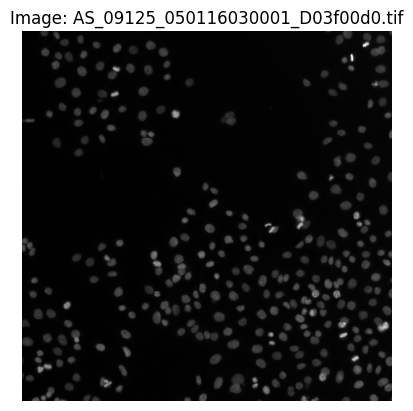

In [9]:
# Iterate through the records and display the images
for index, row in db.open_table("images").to_pandas().iterrows():
    img_array = np.array(row["image"], dtype=row["dtype"]).reshape(
        row["height"], row["width"], row["channels"]
    )
    plt.imshow(img_array.squeeze(), cmap="gray")
    plt.title(f"Image: {row['filename']}")
    plt.axis("off")
    plt.show()

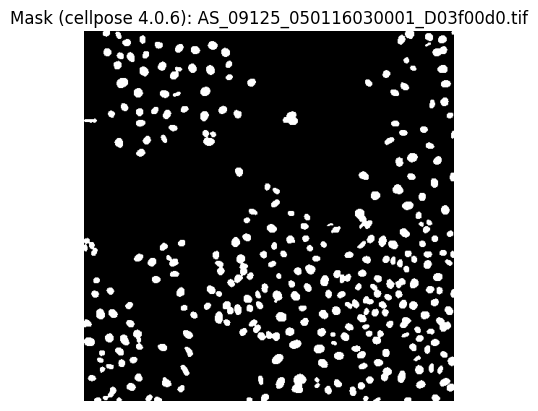

In [10]:
for _, row in db.open_table("masks").to_pandas().iterrows():
    mask = np.array(row["image"], dtype=np.int32).reshape(row["height"], row["width"])
    plt.imshow(mask, cmap="gray", vmin=0, vmax=1)
    plt.title(f"Mask ({row['algo_name']} {row['algo_version']}): {row['filename']}")
    plt.axis("off")
    plt.show()